In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import cv2

import numpy as np

import csv

import matplotlib.pyplot as plt

In [ ]:
#Step0: Load csv driving record files#
#Note: csv file must be at local directory
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.listdir()
os.chdir('/content/gdrive/MyDrive/APS360Group2') #Your local copy dir#

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# PART 1: DATA

In [ ]:
# Step1: Read from the log file
samples = []
with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # Skip the first row
    for line in reader:
        samples.append(line)

此block为测试代码

In [ ]:
#Dvide into two sets: 
train_len = int(0.8*len(samples))
valid_len = int((len(samples) - train_len)/2)
test_len = valid_len
train_samples, validation_samples, test_samples = data.random_split(samples, lengths=[train_len, valid_len, test_len])

In [ ]:
print('train samples size: ', len(train_samples))
print('valid samples size: ', len(validation_samples))
print('test samples size: ', len(test_samples))

train samples size:  6428
valid samples size:  804
test samples size:  804


In [ ]:
def augment(imgName, angle):
  '''
  Input original CSV file image directory, return new Gdrive directory, 
  the numpy array represented image, and correlated data

  Input: 
  - sample list organized from CSV driving record
  - angle: desired turn angle correlated

  Output: 
  - name: new image directory under Gdrive; 
  - current_image: cropped image data array; 
  - angle: desired turn angle correlated; 

  A number of randomly selected images would be flipped. If this is the case, 
  their correlated turn angle would be flipped as well. If this is not the case,
  the angle would be unchanged. 
  '''

  name = '/content/gdrive/MyDrive/APS360Group2/IMG/' + imgName.split('/')[-1]
  current_image = cv2.imread(name)
  current_image = current_image[65:-25, :, :]

  if np.random.rand() < 0.5:
    current_image = cv2.flip(current_image, 1) 
    angle = angle * -1.0  
  #print(name)
  return name, current_image, angle


In [ ]:
class Dataset(data.Dataset):
  '''
  A torch dataset class
  '''
  def __init__(self, samples, transform=None):
    '''
    sample: sample list organized from csv file
    transform: Image transform requirements
    '''
    self.samples = samples
    self.transform = transform

  def __getitem__(self, index):
    '''
    Overwritting default data fetching subclass __getitem__

    Get an instance of driving records, and grouped into three tuples in 
    regards of center, left, and right camera footage; 

    The camera footage (images) will be represented as its numpy array form. 
    Its correlated key (turn degree in this case) will be a float. 

    input: 
    - index: index of given instance in the sample
    output: 
    - three tuples in the forms of (image, correlated data)
    '''
    #===========Index the wanted instance================
    batch_samples = self.samples[index]
    #===========Get the steering angle===================
    steering_angle = stra = float(batch_samples[3])
    #===========Get image address========================
    # This is done via augment function. 
    # For left and right camera footage: An steering angle offset is added to
    # represent the difference of angle between cameras. 
    center_img, steering_angle_center = augment(batch_samples[0], stra)[1:]
    left_img, steering_angle_left = augment(batch_samples[1], stra + 0.4)[1:]
    right_img, steering_angle_right = augment(batch_samples[2], stra - 0.4)[1:]
    #============Image tansformation=====================
    # If transform para are ordered, image will be transformed accordintly
    if self.transform != None: 
      center_img = self.transform(center_img)
      left_img = self.transform(left_img)
      right_img = self.transform(right_img)
    return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)
    
  def __len__(self):
    '''
    Return amount of total samples
    '''
    return len(self.samples)
                                    

In [ ]:
def make_weights_for_balanced_classes(dataset, nclasses=5):                        
    count = [0] * nclasses
    cls  = []
    cls_no = [] 

    print('number of classes established', count)  

    for record_instance, (centers, lefts, rights) in enumerate(dataset): 
        datas = [centers, lefts, rights]
        item = datas[0]      # item: (center_img, steering_angle_center)                                            
        if item[1] < -0.4 and item[1] >= -1:
          count[0] += 1
          cls_no.append(0)
          cls.append('right big')
        elif item[1] >= -0.4 and item[1] < 0:
          count[1] += 1
          cls_no.append(1)
          cls.append('right small')
        elif item[1] == 0:
          count[2] += 1
          cls_no.append(2)
          cls.append('straight')
        elif item[1] > 0 and item[1] <= 0.4:
          count[3] += 1
          cls_no.append(3)
          cls.append('left small')
        elif item[1] > 0.4 and item[1] <= 1:
          count[4] += 1 
          cls_no.append(4)
          cls.append('left big')
        # Debug: 
        print('item class:', cls[-1], 'item angle:', item[1])
        print('count:', record_instance)

    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))        

    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(dataset) 

    for record_instance, (centers, lefts, rights) in enumerate(dataset):
        datas = [centers, lefts, rights]
        item = datas[0]      # item: (center_img, steering_angle_center)                                     
        weight[record_instance] = weight_per_class[cls_no[record_instance]]

    print('weights(str): rightb, rights, straight, lefts, leftb') 
    print('weights(flt):', weight_per_class)
    print('number of weights assigned:', len(weight))

    return weight                           

In [ ]:

# Define transformation parameter: 
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])
training_set = Dataset(train_samples, transformations)
t_weights = make_weights_for_balanced_classes(training_set)
t_weights = torch.DoubleTensor(t_weights)
t_samp = torch.utils.data.sampler.WeightedRandomSampler(t_weights, len(t_weights))


validation_set = Dataset(validation_samples, transformations)
v_weights = make_weights_for_balanced_classes(validation_set)
v_weights = torch.DoubleTensor(v_weights)
v_samp = torch.utils.data.sampler.WeightedRandomSampler(v_weights, len(v_weights))


流式输出内容被截断，只能显示最后 5000 行内容。
count: 4679
item class: left small item angle: 0.08824026
count: 4680
item class: straight item angle: -0.0
count: 4681
item class: straight item angle: -0.0
count: 4682
item class: straight item angle: -0.0
count: 4683
item class: left small item angle: 0.1452064
count: 4684
item class: straight item angle: 0.0
count: 4685
item class: straight item angle: 0.0
count: 4686
item class: left small item angle: 0.2781274
count: 4687
item class: straight item angle: -0.0
count: 4688
item class: right small item angle: -0.07132844
count: 4689
item class: straight item angle: 0.0
count: 4690
item class: left small item angle: 0.06925154
count: 4691
item class: straight item angle: 0.0
count: 4692
item class: straight item angle: 0.0
count: 4693
item class: straight item angle: 0.0
count: 4694
item class: straight item angle: -0.0
count: 4695
item class: left small item angle: 0.1574452
count: 4696
item class: straight item angle: 0.0
count: 4697
item class: left smal

# PART 2: Designed MODEL


In [ ]:
### Create NN Network based on Nividia structure: ###

class NetworkLight(nn.Module):

    def __init__(self):
        super(NetworkLight, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 48, 3, stride=2),
            nn.MaxPool2d(4, stride=4),
            nn.Dropout(p=0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48*4*19, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        

    def forward(self, input):
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        #print('iteration complete, output shape: ', output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

# PART 3: TRAIN

In [ ]:

## GPU acceleration: ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)

def toDevice(datas, device):
  
  imgs, angles = datas
  return imgs.float().to(device), angles.float().to(device)

  

device is:  cpu


In [ ]:
## Train: ##

def train_rnn(model, training_generator, validation_generator, 
              num_epochs=5, learning_rate=1e-4, batch_size = 32,
          debug=True, plot_loss=True, plot_accu=True ):
  
  max_epochs = num_epochs #ORIGINAL 22
  ## Optimizer and Criterion: ##
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.MSELoss()

  ###########Data storing for plotting###########
  #******************************************
  iter_train = []
  iter_vali = []
  iter = []
  m = 0
  n = 0
  
  train_loss = []
  valid_loss = []
  train_accu = []
  valid_accu = []

  for epoch in range(max_epochs):
    model.to(device)
    #model.train()

    ##################Training#####################
    for record_instance, (centers, lefts, rights) in enumerate(training_generator):
      train_loss_iter = 0
      # Number of instance per batch = total set / (epochs * 3)
      # Considering passing through one instance as an interation
      # GPU Acce: 
      centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
      # Split data into three parts: 
      datas = [centers, lefts, rights]  
      # Training:    
      for data in datas:
        imgs, angles = data
        imgs = imgs.float()
        angles = angles.float()
        # Forward Pass: 
        outputs = model(imgs)
        train_loss_i = criterion(outputs, angles.unsqueeze(1))
        train_loss_iter += float(train_loss_i.item())
        # Backward Pass: 
        train_loss_i.backward()
        optimizer.step()
        optimizer.zero_grad()
      
      #********************************************
      train_loss_epoch = train_loss_iter/(batch_size)
      train_loss.append(train_loss_epoch)
      m += 1
      iter_train.append(m)
      
    print("Epoch", epoch+1, " Training process is done!")

    ##################Validation###################
    for record_instance, (centers, lefts, rights) in enumerate(validation_generator):
      valid_loss_iter = 0
      # GPU Acce: 
      centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
      # Split data into three parts: 
      datas = [centers, lefts, rights] 
      # Validation: 
      for data in datas: 
        imgs, angles = data
        imgs = imgs.float()
        angles = angles.float()
        outputs = model(imgs)
        valid_loss_i = criterion(outputs, angles.unsqueeze(1))
        valid_loss_iter += float(valid_loss_i.item())
      #************************************
      valid_loss_epoch = valid_loss_iter/(batch_size)
      valid_loss.append(valid_loss_epoch)
      n+=1
      iter_vali.append(n*8)
    print("Epoch", epoch+1, "Validation process is done!")


    ###############Epoch_Result####################
    '''
    train_accu.append(get_accuracy(model, training_generator)) 
    valid_accu.append(get_accuracy(model, validation_generator))
    '''
    iter.append(epoch+1)

    ###############Debug info######################**************************
    if debug == True: 
      print('Training loss: ', str(train_loss[-1]))
      print('Validation loss: ', str(valid_loss[-1]))    
      '''
      print('Training accuracy: ', str(train_accu[-1]))
      print('Validation accuracy: ', str(valid_accu[-1]))
      '''
      print('---------------------------------')

  ###############Graphing##########################
  if plot_loss == True:
    plt.title("Loss")
    plt.plot(iter_train, train_loss, label="Train loss")
    plt.plot(iter_vali, valid_loss, label="Valid loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  plt.title("Training Curve - Loss")
  plt.plot(iter_train, train_loss, label="Train loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.title("Validation Curve - Loss")
  plt.plot(iter_vali, valid_loss, label="Vali loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  
  return True

In [ ]:
## Get Accuacy ##
def accuracy_testing(model, data_loader): 
  cls_no = [] #Not used
  cls = [] #Class of objects
  output_list = [] 
  err_0 = []
  err_1 = []
  err_2 = []
  err_3 = []
  err_4 = []
  err_list = []
  count = [0,0,0,0,0]
  for record_instance, (centers, lefts, rights) in enumerate(data_loader): 
    datas = [centers, lefts, rights] 
    for data in datas: 
      imgs, angles = data
      imgs = imgs.float()
      angles = angles.float()

      #########################Test the Model####################################  
      outputs = model(imgs)
      output_list.append(outputs.item())
      err = abs(outputs.item() - angles)
      err = err.item()
      err_list.append(err)
    #########################Determine the Turning Class########################
      if angles < -0.4 and angles >= -1:
        count[0] += 1
        cls_no.append(0)
        cls.append('right big')
        err_0.append(err)
      elif angles >= -0.4 and angles < 0:
        count[1] += 1
        cls_no.append(1)
        cls.append('right small')
        err_1.append(err)
      elif angles == 0:
        count[2] += 1
        cls_no.append(2)
        cls.append('straight')
        err_2.append(err)
      elif angles > 0 and angles <= 0.4:
        count[3] += 1
        cls_no.append(3)
        cls.append('left small')
        err_3.append(err)
      elif angles > 0.4 and angles <= 1:
        count[4] += 1 
        cls_no.append(4)
        cls.append('left big')
        err_4.append(err)
      
      angles = angles.item()
     ############################Record#########################################
      print('======================================')
      print('instance: %s, turn: %s, angles: %s, outputs: %s, error: %s '
    %(record_instance, cls[-1], angles, outputs.item(), err_list[-1]))
  
  ##########################Graphing#########################################
  avg_err = []
  avg_err.append((sum(err_4)/count[4])*45)
  avg_err.append((sum(err_3)/count[3])*45)
  avg_err.append((sum(err_2)/count[2])*45)
  avg_err.append((sum(err_1)/count[1])*45)
  avg_err.append((sum(err_0)/count[0])*45)

  fig, ax = plt.subplots()
  plt.bar(np.arange(5), avg_err, width=0.35)

  ax.set_xticks(np.arange(5))
  ax.set_xticklabels(('Left Sharp', 'Left', 'Straight', 
                      'Right ', 'Right Sharp'))
  ax.set_ylabel('error in degrees')
  ax.set_title('Difference between model steering commands against ideal turn angles')
  ax.legend()

  
  print("avg error for class1:", sum(err_0)/count[0], 
        "class2:", sum(err_1)/count[1], 
        "class3:", sum(err_2)/count[2], 
        "class4:", sum(err_3)/count[3], 
        "calss5:", sum(err_4)/count[4])

  return err

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.00973671954125166
Validation loss:  0.005529708927497268
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.006462217075750232
Validation loss:  0.00529746466781944
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.00531303696334362
Validation loss:  0.01212758058682084
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.00428284949157387
Validation loss:  0.0036410350585356355
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.00460377405397594
Validation loss:  0.0038315840356517583
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss:  0.0060721205

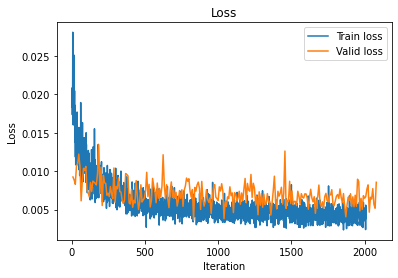

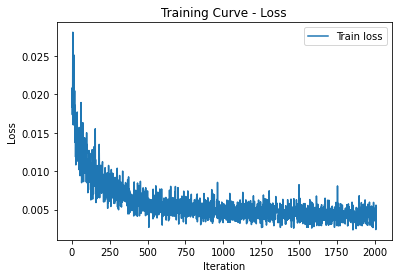

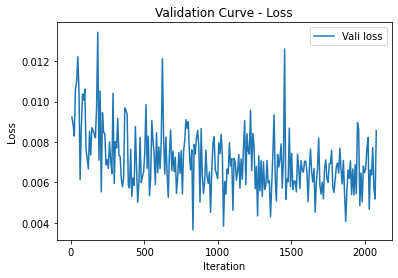

True

In [ ]:
# Define dataloader parameter: 
params = {'batch_size': 32     ,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model1 = NetworkLight()
train_rnn(model1, training_generator, validation_generator, 
              num_epochs=10, learning_rate=0.0001, batch_size = 32,
          debug=True, plot_loss=True, plot_accu=True )

流式输出内容被截断，只能显示最后 5000 行内容。
instance: 5588, turn: left big, angles: 0.5167232751846313, outputs: 0.5932231545448303, error: 0.07649987936019897 
instance: 5589, turn: right big, angles: -0.43953150510787964, outputs: -0.2752229869365692, error: 0.16430851817131042 
instance: 5589, turn: right small, angles: -0.03953149914741516, outputs: -0.14450456202030182, error: 0.10497306287288666 
instance: 5589, turn: left big, angles: 0.8395314812660217, outputs: 0.907004177570343, error: 0.06747269630432129 
instance: 5590, turn: right big, angles: -0.44902580976486206, outputs: -0.5581746697425842, error: 0.10914885997772217 
instance: 5590, turn: right small, angles: -0.049025800079107285, outputs: -0.1428581178188324, error: 0.09383231401443481 
instance: 5590, turn: right big, angles: -0.8490257859230042, outputs: -0.6492494940757751, error: 0.199776291847229 
instance: 5591, turn: right big, angles: -0.41104841232299805, outputs: -0.365614652633667, error: 0.045433759689331055 
instance: 5

No handles with labels found to put in legend.


instance: 6422, turn: left small, angles: 0.07132843881845474, outputs: 0.011531587690114975, error: 0.05979685112833977 
instance: 6422, turn: right big, angles: -0.4713284373283386, outputs: -0.37335333228111267, error: 0.09797510504722595 
instance: 6422, turn: left small, angles: 0.32867157459259033, outputs: 0.20241250097751617, error: 0.12625907361507416 
instance: 6423, turn: right small, angles: -0.0027910429053008556, outputs: 0.2494090050458908, error: 0.25220003724098206 
instance: 6423, turn: right small, angles: -0.39720895886421204, outputs: -0.4264589846134186, error: 0.029250025749206543 
instance: 6423, turn: left big, angles: 0.4027910530567169, outputs: -0.06927936524152756, error: 0.4720704257488251 
instance: 6424, turn: right big, angles: -0.46363818645477295, outputs: -0.5852007269859314, error: 0.12156254053115845 
instance: 6424, turn: left big, angles: 0.8636382222175598, outputs: 1.0442352294921875, error: 0.18059700727462769 
instance: 6424, turn: right smal

No handles with labels found to put in legend.


instance: 799, turn: left big, angles: 0.46363818645477295, outputs: 0.4201626181602478, error: 0.043475568294525146 
instance: 799, turn: left big, angles: 0.8636382222175598, outputs: 0.8319182991981506, error: 0.03171992301940918 
instance: 799, turn: right small, angles: -0.06363820284605026, outputs: 0.058349501341581345, error: 0.12198770046234131 
instance: 800, turn: left big, angles: 0.44902580976486206, outputs: 0.23294700682163239, error: 0.21607880294322968 
instance: 800, turn: right small, angles: -0.049025800079107285, outputs: 0.1433168649673462, error: 0.19234266877174377 
instance: 800, turn: left big, angles: 0.8490257859230042, outputs: 0.5561429858207703, error: 0.2928828001022339 
instance: 801, turn: left big, angles: 0.44902580976486206, outputs: 0.37090590596199036, error: 0.0781199038028717 
instance: 801, turn: right small, angles: -0.049025800079107285, outputs: -0.08872121572494507, error: 0.039695415645837784 
instance: 801, turn: left big, angles: 0.84902

0.04591947793960571

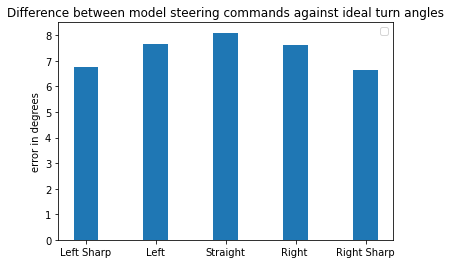

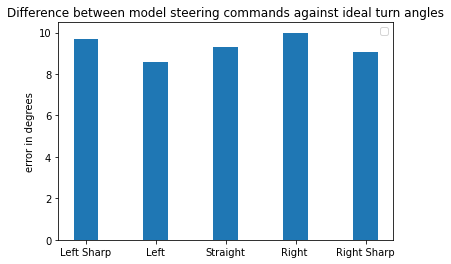

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model1, data_loader = training_generator)
accuracy_testing(model1, data_loader = validation_generator)

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.004402734339237213
Validation loss:  0.004563571244943887
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.0027442159480415285
Validation loss:  0.0035875290050171316
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.0025111951981671154
Validation loss:  0.004169864812865853
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.0031080616754479706
Validation loss:  0.003311550128273666
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.002451385895255953
Validation loss:  0.004652812727726996
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss:  0.00

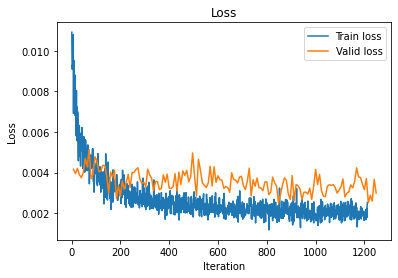

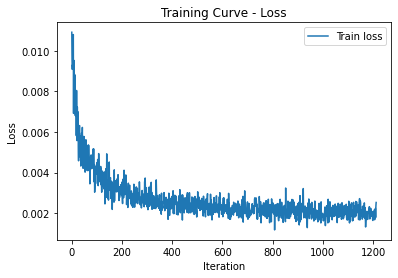

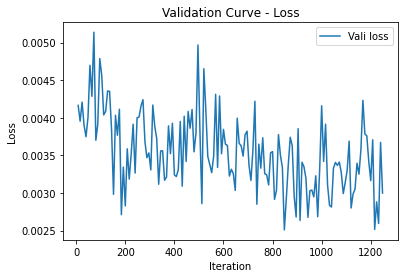

True

In [ ]:
# Define dataloader parameter: 
params = {'batch_size': 64     ,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model2 = NetworkLight()
train_rnn(model2, training_generator, validation_generator, 
              num_epochs=12, learning_rate=0.0002, batch_size = 64,
          debug=True, plot_loss=True, plot_accu=True )

流式输出内容被截断，只能显示最后 5000 行内容。
instance: 5589, turn: left big, angles: 0.4692515432834625, outputs: 0.34760236740112305, error: 0.12164917588233948 
instance: 5590, turn: right big, angles: -0.44902580976486206, outputs: -0.3827093839645386, error: 0.06631642580032349 
instance: 5590, turn: right small, angles: -0.049025800079107285, outputs: 0.01847013458609581, error: 0.0674959346652031 
instance: 5590, turn: right big, angles: -0.8490257859230042, outputs: -0.560452938079834, error: 0.28857284784317017 
instance: 5591, turn: right big, angles: -0.9426953792572021, outputs: -0.6601892709732056, error: 0.2825061082839966 
instance: 5591, turn: right big, angles: -0.5426954030990601, outputs: -0.501689076423645, error: 0.04100632667541504 
instance: 5591, turn: right big, angles: -1.3426953554153442, outputs: -1.2900418043136597, error: 0.05265355110168457 
instance: 5592, turn: right big, angles: -0.42054280638694763, outputs: -0.5439919829368591, error: 0.1234491765499115 
instance: 5592

No handles with labels found to put in legend.


instance: 6423, turn: left small, angles: 0.15744520723819733, outputs: 0.14477501809597015, error: 0.012670189142227173 
instance: 6423, turn: right big, angles: -0.557445228099823, outputs: -0.4764912724494934, error: 0.08095395565032959 
instance: 6423, turn: left small, angles: 0.24255479872226715, outputs: 0.1654934138059616, error: 0.07706138491630554 
instance: 6424, turn: straight, angles: -0.0, outputs: -0.010819933377206326, error: 0.010819933377206326 
instance: 6424, turn: left small, angles: 0.4000000059604645, outputs: 0.3743193745613098, error: 0.025680631399154663 
instance: 6424, turn: left small, angles: 0.4000000059604645, outputs: 0.10087494552135468, error: 0.299125075340271 
instance: 6425, turn: left big, angles: 0.629418671131134, outputs: 0.48403269052505493, error: 0.1453859806060791 
instance: 6425, turn: right small, angles: -0.22941869497299194, outputs: -0.14855854213237762, error: 0.08086015284061432 
instance: 6425, turn: right small, angles: 1.029418706

No handles with labels found to put in legend.


instance: 799, turn: right small, angles: -0.049025800079107285, outputs: -0.012283552438020706, error: 0.03674224764108658 
instance: 799, turn: left big, angles: 0.8490257859230042, outputs: 0.6306483745574951, error: 0.21837741136550903 
instance: 800, turn: left small, angles: 0.14520640671253204, outputs: 0.12118105590343475, error: 0.02402535080909729 
instance: 800, turn: left small, angles: 0.25479361414909363, outputs: -0.00804344192147255, error: 0.2628370523452759 
instance: 800, turn: left big, angles: 0.5452064275741577, outputs: 0.6960660219192505, error: 0.15085959434509277 
instance: 801, turn: left big, angles: 0.5059919953346252, outputs: 0.42727380990982056, error: 0.07871818542480469 
instance: 801, turn: right small, angles: -0.10599199682474136, outputs: -0.12953273952007294, error: 0.023540742695331573 
instance: 801, turn: left big, angles: 0.9059919714927673, outputs: 0.35837507247924805, error: 0.5476168990135193 
instance: 802, turn: right small, angles: -0.1

0.07965528964996338

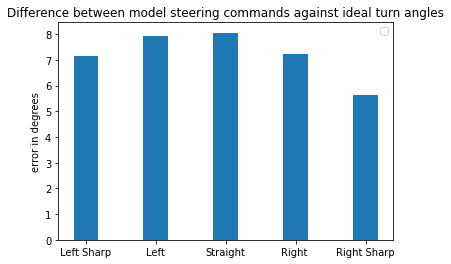

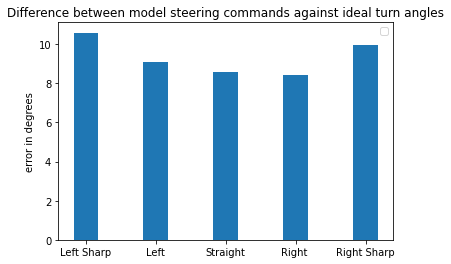

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model2, data_loader = training_generator)
accuracy_testing(model2, data_loader = validation_generator)

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.0023240389418788254
Validation loss:  0.0022051171108614653
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.0016337003035005182
Validation loss:  0.001676288724411279
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.001324922137428075
Validation loss:  0.0017046631255652755
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.0012240723299328238
Validation loss:  0.0018696647020988166
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.0008870625897543505
Validation loss:  0.0016451260598842055
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss:  

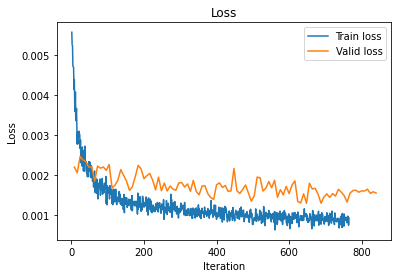

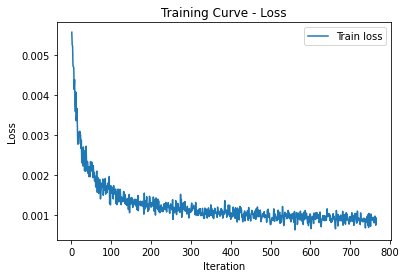

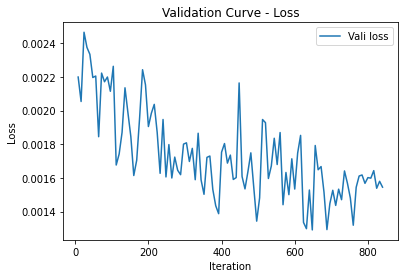

True

In [ ]:
 # Define dataloader parameter: 
params = {'batch_size': 128     ,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model3 = NetworkLight()
train_rnn(model3, training_generator, validation_generator, 
              num_epochs=15, learning_rate=0.0005, batch_size = 128,
          debug=True, plot_loss=True, plot_accu=True )

流式输出内容被截断，只能显示最后 5000 行内容。
instance: 5587, turn: right small, angles: -0.4000000059604645, outputs: -0.28334593772888184, error: 0.11665406823158264 
instance: 5588, turn: right big, angles: -0.5344750881195068, outputs: -0.3061859607696533, error: 0.22828912734985352 
instance: 5588, turn: right small, angles: -0.13447509706020355, outputs: -0.0796557292342186, error: 0.054819367825984955 
instance: 5588, turn: left big, angles: 0.9344751238822937, outputs: 0.6662547588348389, error: 0.26822036504745483 
instance: 5589, turn: straight, angles: 0.0, outputs: -0.08694367855787277, error: 0.08694367855787277 
instance: 5589, turn: left small, angles: 0.4000000059604645, outputs: 0.1557387113571167, error: 0.24426129460334778 
instance: 5589, turn: left small, angles: 0.4000000059604645, outputs: 0.39970898628234863, error: 0.0002910196781158447 
instance: 5590, turn: left big, angles: 0.5784605741500854, outputs: 0.46864941716194153, error: 0.10981115698814392 
instance: 5590, turn: left

No handles with labels found to put in legend.


instance: 6421, turn: right big, angles: -0.5784605741500854, outputs: -0.45092353224754333, error: 0.12753704190254211 
instance: 6421, turn: left big, angles: 0.9784606099128723, outputs: 0.7183617949485779, error: 0.26009881496429443 
instance: 6421, turn: right small, angles: -0.17846059799194336, outputs: -0.03462239354848862, error: 0.14383819699287415 
instance: 6422, turn: left small, angles: 0.3679529130458832, outputs: 0.2599862217903137, error: 0.10796669125556946 
instance: 6422, turn: right big, angles: -0.7679529190063477, outputs: -0.4825756847858429, error: 0.28537723422050476 
instance: 6422, turn: left small, angles: 0.032047100365161896, outputs: -0.051798127591609955, error: 0.08384522795677185 
instance: 6423, turn: left small, angles: 0.272267609834671, outputs: 0.4711281359195709, error: 0.1988605260848999 
instance: 6423, turn: right big, angles: -0.6722676157951355, outputs: -0.5640397667884827, error: 0.10822784900665283 
instance: 6423, turn: left small, angl

0.3899093270301819

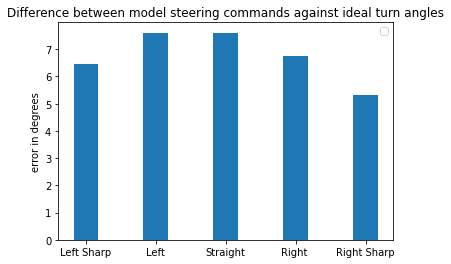

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
accuracy_testing(model3, data_loader = training_generator)

instance: 0, turn: right small, angles: -0.07132843881845474, outputs: -0.38470980525016785, error: 0.3133813738822937 
instance: 0, turn: right big, angles: -0.4713284373283386, outputs: -0.32064494490623474, error: 0.15068349242210388 
instance: 0, turn: right small, angles: -0.32867157459259033, outputs: -0.43457886576652527, error: 0.10590729117393494 
instance: 1, turn: left small, angles: 0.21166689693927765, outputs: 0.008749939501285553, error: 0.2029169499874115 
instance: 1, turn: left small, angles: 0.18833309412002563, outputs: -0.3521701991558075, error: 0.5405032634735107 
instance: 1, turn: left big, angles: 0.6116669178009033, outputs: 0.8404502868652344, error: 0.22878336906433105 
instance: 2, turn: right big, angles: -0.5059919953346252, outputs: -0.46582475304603577, error: 0.04016724228858948 
instance: 2, turn: right small, angles: -0.10599199682474136, outputs: -0.3071218430995941, error: 0.20112985372543335 
instance: 2, turn: left big, angles: 0.905991971492767

No handles with labels found to put in legend.


instance: 799, turn: left small, angles: 0.4000000059604645, outputs: 0.5896711945533752, error: 0.18967118859291077 
instance: 799, turn: left small, angles: 0.4000000059604645, outputs: 0.12840741872787476, error: 0.2715925872325897 
instance: 800, turn: left big, angles: 0.45406970381736755, outputs: 0.4448336660861969, error: 0.009236037731170654 
instance: 800, turn: left big, angles: 0.854069709777832, outputs: 1.0699102878570557, error: 0.21584057807922363 
instance: 800, turn: right small, angles: -0.054069701582193375, outputs: -0.33078819513320923, error: 0.27671849727630615 
instance: 801, turn: right small, angles: -0.28183621168136597, outputs: 0.05068114399909973, error: 0.3325173556804657 
instance: 801, turn: right big, angles: -0.6818361878395081, outputs: -0.2711036801338196, error: 0.4107325077056885 
instance: 801, turn: right small, angles: -0.11816380172967911, outputs: -0.30316880345344543, error: 0.18500500917434692 
instance: 802, turn: left small, angles: 0.30

0.1891995370388031

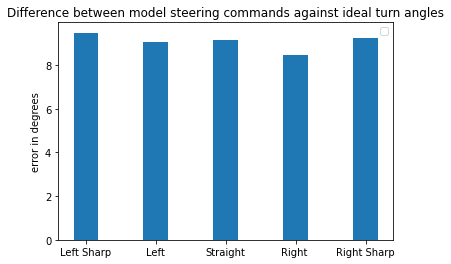

In [ ]:
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model3, data_loader = validation_generator)

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.0010906739044003189
Validation loss:  0.0013778723950963467
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.0008630511874798685
Validation loss:  0.0010903405491262674
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.0010067011753562838
Validation loss:  0.0007971904706209898
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.00047073880705283955
Validation loss:  0.001127414929214865
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.000512545884703286
Validation loss:  0.0011379692296031862
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss: 

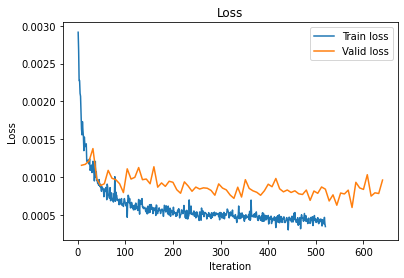

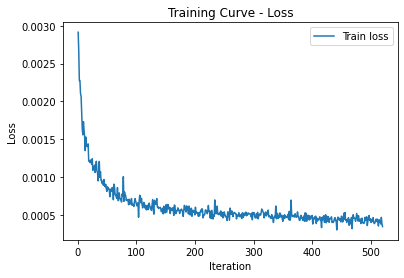

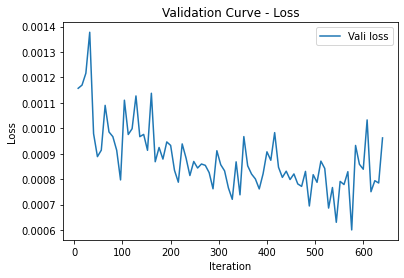

True

In [ ]:
 # Define dataloader parameter: 
params = {'batch_size': 256,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model4 = NetworkLight()
train_rnn(model4, training_generator, validation_generator, 
              num_epochs=20, learning_rate=0.001, batch_size = 256,
          debug=True, plot_loss=True, plot_accu=True )

流式输出内容被截断，只能显示最后 5000 行内容。
instance: 5591, turn: left small, angles: -1.029418706893921, outputs: -1.101609706878662, error: 0.07219099998474121 
instance: 5592, turn: right small, angles: -0.13830819725990295, outputs: -0.46448904275894165, error: 0.3261808454990387 
instance: 5592, turn: right big, angles: -0.5383082032203674, outputs: -0.6082260012626648, error: 0.06991779804229736 
instance: 5592, turn: left small, angles: 0.2616918087005615, outputs: -0.12135051935911179, error: 0.3830423355102539 
instance: 5593, turn: straight, angles: 0.0, outputs: -0.1703992486000061, error: 0.1703992486000061 
instance: 5593, turn: left small, angles: 0.4000000059604645, outputs: 0.3508095443248749, error: 0.0491904616355896 
instance: 5593, turn: left small, angles: 0.4000000059604645, outputs: 0.28584447503089905, error: 0.11415553092956543 
instance: 5594, turn: left small, angles: 0.21166689693927765, outputs: 0.20572692155838013, error: 0.005939975380897522 
instance: 5594, turn: right s

No handles with labels found to put in legend.


instance: 6425, turn: left small, angles: 0.01391724031418562, outputs: -0.21394482254981995, error: 0.22786206007003784 
instance: 6425, turn: right big, angles: -0.4139172434806824, outputs: -0.20085856318473816, error: 0.2130586802959442 
instance: 6425, turn: left small, angles: 0.3860827684402466, outputs: 0.6398671865463257, error: 0.2537844181060791 
instance: 6426, turn: left small, angles: 0.205287903547287, outputs: 0.5797476768493652, error: 0.37445977330207825 
instance: 6426, turn: right big, angles: -0.6052879095077515, outputs: -0.455468088388443, error: 0.14981982111930847 
instance: 6426, turn: left small, angles: 0.1947121024131775, outputs: -0.06306550651788712, error: 0.257777601480484 
instance: 6427, turn: left small, angles: 0.06175990030169487, outputs: 0.21777239441871643, error: 0.15601249039173126 
instance: 6427, turn: left big, angles: 0.46175989508628845, outputs: 0.3926285207271576, error: 0.06913137435913086 
instance: 6427, turn: left small, angles: 0.3

0.03189757466316223

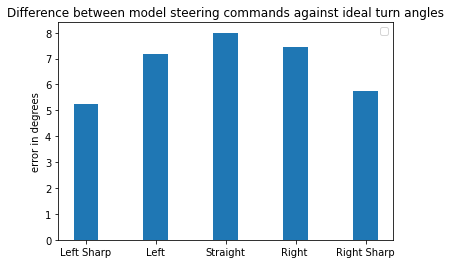

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 1}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
accuracy_testing(model4, data_loader = training_generator)


instance: 0, turn: right small, angles: -0.15744520723819733, outputs: -0.40560340881347656, error: 0.24815820157527924 
instance: 0, turn: right big, angles: -0.557445228099823, outputs: -0.6117885112762451, error: 0.05434328317642212 
instance: 0, turn: right small, angles: -0.24255479872226715, outputs: 0.10770005732774734, error: 0.3502548635005951 
instance: 1, turn: right big, angles: -0.6550089120864868, outputs: -0.20527389645576477, error: 0.44973501563072205 
instance: 1, turn: right big, angles: 1.055008888244629, outputs: 0.6910146474838257, error: 0.3639942407608032 
instance: 1, turn: right small, angles: -0.25500890612602234, outputs: 0.02905426174402237, error: 0.2840631604194641 
instance: 2, turn: right big, angles: -0.44902580976486206, outputs: -0.2827863097190857, error: 0.16623950004577637 
instance: 2, turn: right small, angles: -0.049025800079107285, outputs: 0.12031882256269455, error: 0.16934461891651154 
instance: 2, turn: left big, angles: 0.8490257859230042

No handles with labels found to put in legend.


instance: 798, turn: left big, angles: 0.8490257859230042, outputs: 0.5699883699417114, error: 0.2790374159812927 
instance: 799, turn: right big, angles: -0.49234381318092346, outputs: -0.28809788823127747, error: 0.204245924949646 
instance: 799, turn: left big, angles: 0.8923438191413879, outputs: 0.7703064680099487, error: 0.12203735113143921 
instance: 799, turn: right small, angles: -0.09234379976987839, outputs: -0.1818886697292328, error: 0.0895448699593544 
instance: 800, turn: left big, angles: 0.45406970381736755, outputs: 0.38651812076568604, error: 0.06755158305168152 
instance: 800, turn: left big, angles: 0.854069709777832, outputs: 0.9560364484786987, error: 0.1019667387008667 
instance: 800, turn: right small, angles: -0.054069701582193375, outputs: -0.3324829936027527, error: 0.2784132957458496 
instance: 801, turn: left small, angles: 0.031274110078811646, outputs: 0.006940819323062897, error: 0.02433329075574875 
instance: 801, turn: right small, angles: -0.36872589

0.13082528114318848

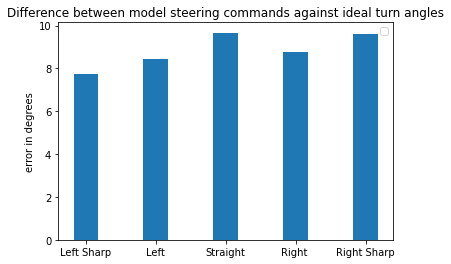

In [ ]:
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model4, data_loader = validation_generator)

#Part 4: Testing

In [ ]:
test_set = Dataset(test_samples, transformations)
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 1}
test_generator = DataLoader(test_set, **params)

instance: 0, turn: straight, angles: -0.0, outputs: 0.057716965675354004, error: 0.057716965675354004 
instance: 0, turn: right small, angles: -0.4000000059604645, outputs: -0.09046099334955215, error: 0.3095390200614929 
instance: 0, turn: right small, angles: -0.4000000059604645, outputs: -0.2224263846874237, error: 0.17757362127304077 
instance: 1, turn: right small, angles: -0.3679529130458832, outputs: 0.40846309065818787, error: 0.776416003704071 
instance: 1, turn: left big, angles: 0.7679529190063477, outputs: -0.15149039030075073, error: 0.9194433093070984 
instance: 1, turn: left small, angles: 0.032047100365161896, outputs: 0.3486896753311157, error: 0.3166425824165344 
instance: 2, turn: straight, angles: 0.0, outputs: -0.03355615586042404, error: 0.03355615586042404 
instance: 2, turn: left small, angles: 0.4000000059604645, outputs: 0.232954204082489, error: 0.16704580187797546 
instance: 2, turn: left small, angles: 0.4000000059604645, outputs: 0.46830040216445923, error

No handles with labels found to put in legend.


avg error for class1: 0.19009046092629434 class2: 0.1863131569461676 class3: 0.17662485469685216 class4: 0.2090313654722801 calss5: 0.20203455785910288


0.18303081393241882

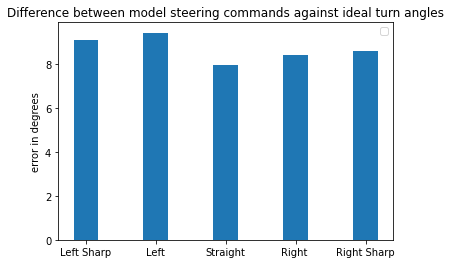

In [ ]:
accuracy_testing(model3, data_loader = test_generator)

# Part 5: Model Saving

In [ ]:
state = {
        'model': model.module if device == 'cuda' else model,
        }

torch.save(state, 'model.h5')

# Part 6: Nvidia Model
For reference

In [ ]:
class NetworkDense(nn.Module):

    def __init__(self):
        super(NetworkDense, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 2 * 33, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        
    def forward(self, input):  
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [ ]:
# Define dataloader parameter: 
params = {'batch_size': 32,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model_nvidia = NetworkDense()
train_rnn(model_nvidia, training_generator, validation_generator, 
              num_epochs=15, learning_rate=0.0001, batch_size = 32,
          debug=True, plot_loss=True, plot_accu=True )

In [ ]:
params = {'batch_size': 128,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model_nvidia_128 = NetworkDense()
train_rnn(model_nvidia_128, training_generator, validation_generator, 
              num_epochs=15, learning_rate=0.0005, batch_size = 128,
          debug=True, plot_loss=True, plot_accu=True )